# Equity premium prediction with python and Keras

* An exploratory data analysis and a demo of classification using a feedforward neural network written in python using the [Keras](https://keras.io/) machine learning framework
* Using [dataset](http://www.hec.unil.ch/agoyal/docs/PredictorData2016.xlsx) from [Prof. Amit Goyal](http://www.hec.unil.ch/agoyal/), we attempt to predict quarterly equity outperformance based on fundamental data like interest rates, valuation.
* Train binary classifier to predict whether next quarter's equity premium will be above or below long term average


In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight

from pprint import pprint
import time
import copy


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json

import matplotlib.pyplot as plt

#use a fixed seed for reproducibility
#seed = np.random.randint(10000, size=1)[0]
seed = 6882
print(seed)
np.random.seed(seed)


Using TensorFlow backend.


6882


In [2]:
############################################################
# 1. load data
############################################################

# load dataset
print("Loading data...")
dataframe = pd.read_csv("EqPremClass.csv")
dataframe

Loading data...


,Unnamed: 0,D12,E12,b.m,tbl,AAA,BAA,lty,ntis,infl,...,ltr.diff,corpr.diff,svar.diff,tbl.lagdiff,AAA.lagdiff,BAA.lagdiff,lty.lagdiff,ltr.lagdiff,corpr.lagdiff,EqPremResponse
0,3,0.770,1.110,0.374689,0.0317,0.050313,0.058913,0.037313,0.076475,-0.005713,...,0.012577,-0.004409,0.000268,-0.0035,-0.011438,-0.012138,-0.012838,0.030167,0.005259,1
1,4,0.790,1.177,0.363255,0.0327,0.044430,0.053030,0.031530,0.054364,0.000170,...,-0.020049,-0.005564,-0.000161,0.0013,0.016741,0.015941,0.015041,0.007711,-0.000199,0
2,5,0.810,1.245,0.370300,0.0392,0.045530,0.055330,0.032430,0.050299,0.000170,...,-0.011019,-0.022453,0.004100,-0.0013,-0.029141,-0.028641,-0.028441,-0.038657,-0.012230,1
3,6,0.830,1.312,0.328166,0.0457,0.040150,0.049950,0.028650,0.027980,0.005950,...,-0.014276,0.019109,-0.003478,-0.0039,0.011161,0.010261,0.011161,0.011038,0.014918,1
4,7,0.850,1.380,0.259667,0.0426,0.051744,0.061644,0.039644,0.063069,-0.005644,...,0.034818,0.002796,0.002725,0.0049,-0.006513,-0.006713,-0.007113,0.012577,-0.004409,1
5,8,0.880,1.438,0.272300,0.0460,0.064443,0.075343,0.055143,0.079805,-0.017443,...,-0.055116,-0.014560,0.001703,0.0010,-0.005882,-0.005882,-0.005782,-0.020049,-0.005564,1
6,9,0.910,1.495,0.253581,0.0480,0.088744,0.100444,0.077744,0.116197,-0.041044,...,0.060579,0.003230,0.000422,0.0065,0.001100,0.002300,0.000900,-0.011019,-0.022453,1
7,10,0.940,1.552,0.244868,0.0458,0.113384,0.126584,0.102884,0.121390,-0.065384,...,-0.022683,0.005639,-0.000348,0.0065,-0.005380,-0.005380,-0.003780,-0.014276,0.019109,0
8,11,0.970,1.610,0.338458,0.0303,0.125698,0.138498,0.112998,0.163522,-0.078998,...,0.053953,0.017375,0.092115,-0.0031,0.011594,0.011694,0.010994,0.034818,0.002796,1
9,12,0.973,1.450,0.319119,0.0295,0.151332,0.162432,0.138632,0.145496,-0.105132,...,-0.037758,0.002332,-0.095509,0.0034,0.012700,0.013700,0.015500,-0.055116,-0.014560,0


In [3]:
# pandas dataframe -> numpy ndarray
dataset = dataframe.values
del dataframe

In [4]:
num_obs, num_features = dataset.shape
num_features -=1
num_labels=1
print("Observations: %d\nFeatures: %d" % (num_obs, num_features))

# last column is target 
y=dataset[:,num_features].astype(float)
print("Histogram: check all 0s and 1s, no -1s etc.")
pprint(np.histogram(y))

# omit 1st id column
X_raw = dataset[:,1:num_features].astype(float)
num_features -=1
del dataset

# normalize
# not necessary for NN but may speed convergence, lets pca work
# min_max_scaler = preprocessing.MinMaxScaler()
# X = min_max_scaler.fit_transform(X_raw)
X = preprocessing.scale(X_raw)

pd.DataFrame(X)

Observations: 352
Features: 31
Histogram: check all 0s and 1s, no -1s etc.
(array([176,   0,   0,   0,   0,   0,   0,   0,   0, 176]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.767621,-0.689589,-0.774685,-0.099709,0.519319,0.428291,0.379438,2.381861,-0.910326,0.266007,...,0.421662,0.185423,-0.071273,0.018805,-0.398291,-0.782983,-0.821576,-0.870520,0.451925,0.085675
1,-0.765478,-0.686961,-0.817516,-0.067674,0.380785,0.297435,0.240222,1.486580,-0.762275,-0.164262,...,0.434384,-0.299704,-0.089852,-0.014161,0.163439,1.163271,1.096738,1.035651,0.114856,-0.002960
2,-0.763335,-0.684293,-0.791125,0.140554,0.406691,0.348599,0.261890,1.321980,-0.762275,-0.400750,...,-0.006831,-0.165443,-0.361633,0.313814,-0.140831,-2.005689,-1.949039,-1.937349,-0.581140,-0.198327
3,-0.761192,-0.681664,-0.948962,0.348782,0.279979,0.228911,0.170875,0.418281,-0.616790,-0.707137,...,0.426733,-0.213873,0.307189,-0.269523,-0.445101,0.777854,0.708668,0.770342,0.164790,0.242523
4,-0.759049,-0.678996,-1.205563,0.249473,0.553026,0.489048,0.435564,1.839043,-0.908595,0.040092,...,-0.876449,0.516128,0.044673,0.207974,0.584736,-0.442798,-0.450921,-0.479058,0.187893,-0.071330
5,-0.755834,-0.676721,-1.158236,0.358393,0.852110,0.793800,0.808729,2.516687,-1.205575,-1.142770,...,-0.891871,-0.821140,-0.234620,0.129286,0.128331,-0.399259,-0.394191,-0.388096,-0.301823,-0.090078
6,-0.752620,-0.674484,-1.228362,0.422463,1.424413,1.352177,1.352862,3.990253,-1.799575,0.157329,...,-1.777035,0.899185,0.051657,0.030703,0.771979,0.082991,0.164810,0.068793,-0.166292,-0.364338
7,-0.749405,-0.672248,-1.260999,0.351986,2.004710,1.933677,1.958135,4.200511,-2.412188,-0.329478,...,-1.832500,-0.338877,0.090419,-0.028619,0.771979,-0.364587,-0.359895,-0.251214,-0.215180,0.310585
8,-0.746191,-0.669973,-0.910407,-0.144558,2.294717,2.198710,2.201640,5.906464,-2.754837,0.828413,...,-1.027973,0.800656,0.279277,7.089744,-0.351480,0.807774,0.806583,0.758939,0.521726,0.045674
9,-0.745869,-0.676250,-0.982851,-0.170187,2.898424,2.731137,2.818806,5.176581,-3.412602,0.018082,...,-1.967060,-0.563031,0.037204,-7.354659,0.409195,0.884135,0.943601,1.066998,-0.828192,-0.236167


In [5]:
print("Split into training, xval, test")
# split into training, xval, test, 60/20/20
X_bigtrain, X_test, y_bigtrain, y_test = train_test_split(X, y, test_size=0.2)
print("Split into train, xval")
X_train, X_xval, y_train, y_xval = train_test_split(X_bigtrain, y_bigtrain, test_size=0.25)

print "Training set"
print X_train.shape
pprint(np.histogram(y_train))

print "Xval set"
print X_xval.shape
pprint(np.histogram(y_xval))

print "Test set"
print X_test.shape
pprint(np.histogram(y_test))

Split into training, xval, test
Split into train, xval
Training set
(210, 30)
(array([103,   0,   0,   0,   0,   0,   0,   0,   0, 107]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
Xval set
(71, 30)
(array([36,  0,  0,  0,  0,  0,  0,  0,  0, 35]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
Test set
(71, 30)
(array([37,  0,  0,  0,  0,  0,  0,  0,  0, 34]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))


[ 17.07  32.24  44.    54.6   63.46  69.6   74.57  79.08  82.88  85.83
  88.46  90.63  92.59  94.25  95.78  96.88  97.91  98.63  99.12  99.48
  99.62  99.73  99.81  99.87  99.91  99.93  99.95  99.96  99.97  99.97]


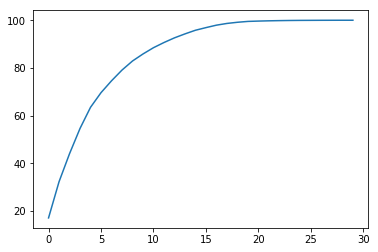

In [6]:
# principal component analysis
# scree chart to see how much variation is explained by how many predictors

# we can predict using PCA components for dimensionality reduction when we have too many/collinear columns
# can speed things up or sometimes get a better result
# but won't do that here
# merely exploratory to understand the data, see that it's scaled

pca = PCA(n_components=num_features)
pca.fit(X_train)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

#print(var1)
%matplotlib inline
plt.plot(var1)
print(var1)
# looks like ~10 orthogonal PCA components explain > 80% of the variation

num_pca_components=15
pca = PCA(n_components=num_pca_components)
pca.fit(X_train)

pca_train=pca.transform(preprocessing.normalize(X_train))
pca_bigtrain=pca.transform(preprocessing.normalize(X_bigtrain))
pca_xval=pca.transform(preprocessing.normalize(X_xval))
pca_test=pca.transform(preprocessing.normalize(X_test))

In [7]:
# function to instantiate Keras feed-forward neural network model

def declare_model(num_components=num_features, 
                  hidden_layer_size=30, 
                  dropout=(1.0/3.0), 
                  reg_penalty=0.0001, 
                  activation='relu'):
    # create model
    model = Sequential()
    # 1 hidden layer of specified size hidden_layer_size, specified L1 regularization, specified activation
    model.add(Dense(hidden_layer_size, 
                    input_dim=num_components, 
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=regularizers.l1(reg_penalty),
                    activation=activation
                   ))
    # 1 dropout layer
    model.add(Dropout(dropout))
    # send outputs to sigmoid layer for binary classification
    model.add(Dense(1, 
                    activation='sigmoid',
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=regularizers.l1(reg_penalty)
                   ))
    return model

def create_model(num_components=num_features, 
                 hidden_layer_size=30, 
                 dropout=(1.0/3.0), 
                 reg_penalty=0.0001, 
                 activation='relu'):
    
    model = declare_model(num_components=num_components, 
                 hidden_layer_size=hidden_layer_size, 
                 dropout=dropout, 
                 reg_penalty=reg_penalty, 
                 activation=activation)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [8]:
# run this a couple of different ways
# 1st, run a simple model

ac='sigmoid'    # sigmoid activation
hl = 8          # 8 hidden units
dr = 0          # no dropout
rp = 0          # no regularization

model = create_model(num_components=num_features, 
                 hidden_layer_size=hl, 
                 dropout=dr, 
                 reg_penalty=rp, 
                 activation=ac)

# recompile with SGD which doesn't work as quickly, shows more readable progress plots
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.SGD(lr=1, clipnorm=1.),
              metrics=['accuracy'])

# fit model on training data
print('%s Training...' % time.strftime("%H:%M:%S"))

fit = model.fit(X_train, y_train, validation_data=(X_xval, y_xval), 
                                    epochs=1000, 
                                    batch_size=X_train.shape[0], # small data, full batch, no sgd 
                                    verbose=False)
# See how it does on training data
# predict probabilities
y_train_prob = model.predict(X_train)
                
# select threshold that maximizes accuracy
def selectThresholdAcc (logits, labels, beta=1):
    # return threshold that yields best accuracy
    # predict using true if >= threshold

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, logits)
    accuracies = [sklearn.metrics.accuracy_score(logits >= thresh, labels) for thresh in thresholds]
    
    best_index = np.argmax(accuracies)
    best_threshold = thresholds[best_index]
    best_score = accuracies[best_index]
    return (best_threshold, best_score)

thresh, score = selectThresholdAcc(y_train_prob, y_train)

# predict true if predicted prob > threshold
y_train_pred = y_train_prob >= thresh
         
# show training accuracy and F1
# (see https://en.wikipedia.org/wiki/F1_score , https://en.wikipedia.org/wiki/Receiver_operating_characteristic )
print("%s Train Accuracy %.3f, Train F1 %.3f" % 
      (time.strftime("%H:%M:%S"),
       sklearn.metrics.accuracy_score(y_train_pred, y_train), 
       sklearn.metrics.f1_score(y_train_pred, y_train)))
                
# show training set confusion matrix 
# True negative      False negative
# False postiive     True positive

print "%s Confusion matrix (train):" % time.strftime("%H:%M:%S")
print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))

# same in cross-validation set
y_xval_prob = model.predict(X_xval)
thresh, score = selectThresholdAcc(y_xval_prob, y_xval)
y_xval_pred = y_xval_prob >= thresh

print("%s Xval Accuracy %.3f, Xval F1 %.3f" % 
      (time.strftime("%H:%M:%S"),
       sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
       sklearn.metrics.f1_score(y_xval_pred, y_xval)))

print "%s Confusion matrix (xval):" % time.strftime("%H:%M:%S")
print(sklearn.metrics.confusion_matrix(y_xval_pred, y_xval))

# same in test
# note we use threshold selected using xval
y_test_prob = model.predict(X_test)
y_test_pred = y_test_prob >= thresh
print("%s Test Accuracy %.3f, Test F1 %.3f" % 
      (time.strftime("%H:%M:%S"),
       sklearn.metrics.accuracy_score(y_test_pred, y_test), 
       sklearn.metrics.f1_score(y_test_pred, y_test)))

print "%s Confusion matrix (test):" % time.strftime("%H:%M:%S")
print(sklearn.metrics.confusion_matrix(y_test_pred, y_test))


21:07:34 Training...
21:07:36 Train Accuracy 0.952, Train F1 0.955
21:07:36 Confusion matrix (train):
[[ 95   2]
 [  8 105]]
21:07:36 Xval Accuracy 0.577, Xval F1 0.571
21:07:36 Confusion matrix (xval):
[[21 15]
 [15 20]]
21:07:36 Test Accuracy 0.577, Test F1 0.545
21:07:36 Confusion matrix (test):
[[23 16]
 [14 18]]


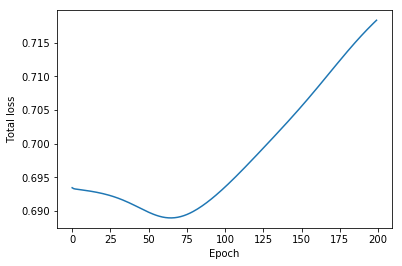

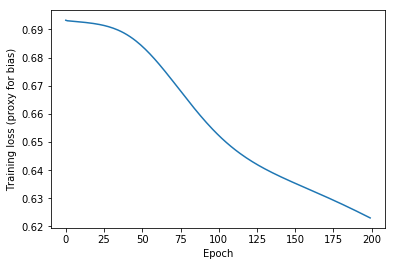

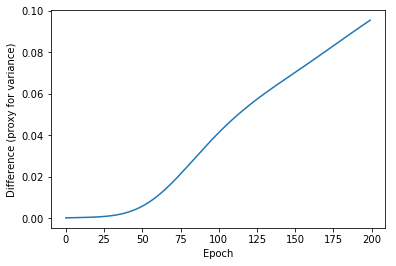

In [9]:
# plot path of loss function over first 200 epochs
# xval loss, proxy for total error 
total_loss = np.array(fit.history['val_loss'][:200])
# training loss, proxy for bias error
bias = np.array(fit.history['loss'][:200])
# difference, proxy for variance error
variance = total_loss - bias

plt.plot(total_loss)
plt.ylabel('Total loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(bias)
plt.ylabel('Training loss (proxy for bias)')
plt.xlabel('Epoch')
plt.show()

plt.plot(variance)
plt.ylabel('Difference (proxy for variance)')
plt.xlabel('Epoch')
plt.show()

# note that training loss (bias) declines continuously
# total loss declines, reaches a minimum, then climbs as overfitting and variance increases
# http://scott.fortmann-roe.com/docs/BiasVariance.html



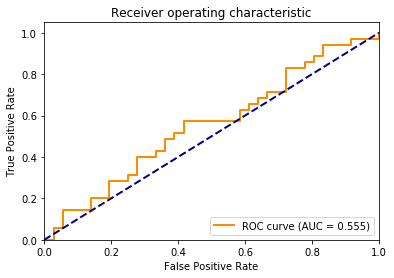

In [10]:
# plot ROC curve

# at bottom left we classify everything as negative, no true positives, no false positives
# as we lower the threshold at which we classify positive, we get some true positives, some false positives
# https://en.wikipedia.org/wiki/Receiver_operating_characteristic

# AUC of a coinflip is 0.5 so area under curve (AUC) ~0.5 is not good
# but highest, lowest prob predictions have predictive value

(fpr, tpr, thresholds) = sklearn.metrics.roc_curve(y_xval, y_xval_prob)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



In [11]:
# 2nd, use Keras native k-fold cross-validation and grid search
# this will take some time ~ note timestamps in output on AWS p2.xlarge

print('%s Starting' % time.strftime("%H:%M:%S"))

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# hyperparameter options to try
hidden_layer_hp = [8, 16, 32]
dropout_hp = [0, 0.333, 0.5]
reg_penalty_hp = [0, 0.0001, 0.0003, 0.001, 0.003]
activation_hp = ['relu','sigmoid']

param_grid = dict(hidden_layer_size=hidden_layer_hp, 
                  dropout=dropout_hp, 
                  reg_penalty=reg_penalty_hp,
                  activation=activation_hp,
                  )

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=kfold)
print('%s Starting grid search' % time.strftime("%H:%M:%S"))
classifier = grid.fit(X_bigtrain, y_bigtrain)

print('%s Finishing' % time.strftime("%H:%M:%S"))

# summarize xval results
print("Best Xval: %f using %s" % (classifier.best_score_, classifier.best_params_))
means = classifier.cv_results_['mean_test_score']
stds = classifier.cv_results_['std_test_score']
params = classifier.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
        
# evaluate with test set
print("Evaluate performance in test set")
y_test_pred = classifier.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test_pred, y_test)
print(confusion_matrix)

print("Test Accuracy %.3f" % sklearn.metrics.accuracy_score(y_test_pred, y_test))
print("Test F1 %.3f" % sklearn.metrics.f1_score(y_test_pred, y_test))

21:07:47 Starting
21:07:47 Starting grid search
22:53:22 Finishing
Best Xval: 0.526690 using {'activation': 'relu', 'hidden_layer_size': 8, 'dropout': 0, 'reg_penalty': 0.0003}
0.491103 (0.063526) with: {'activation': 'relu', 'hidden_layer_size': 8, 'dropout': 0, 'reg_penalty': 0}
0.516014 (0.070171) with: {'activation': 'relu', 'hidden_layer_size': 8, 'dropout': 0, 'reg_penalty': 0.0001}
0.526690 (0.072711) with: {'activation': 'relu', 'hidden_layer_size': 8, 'dropout': 0, 'reg_penalty': 0.0003}
0.508897 (0.047046) with: {'activation': 'relu', 'hidden_layer_size': 8, 'dropout': 0, 'reg_penalty': 0.001}
0.476868 (0.042427) with: {'activation': 'relu', 'hidden_layer_size': 8, 'dropout': 0, 'reg_penalty': 0.003}
0.523132 (0.094458) with: {'activation': 'relu', 'hidden_layer_size': 16, 'dropout': 0, 'reg_penalty': 0}
0.526690 (0.088422) with: {'activation': 'relu', 'hidden_layer_size': 16, 'dropout': 0, 'reg_penalty': 0.0001}
0.508897 (0.041013) with: {'activation': 'relu', 'hidden_layer_

[[18 16]
 [19 18]]
Test Accuracy 0.507
Test F1 0.507


In [11]:
# Finally, roll our own grid search
# more fine-grained control such as custom metric and threshold

# define some custom metrics
import keras.backend as K

def recall(y_true, y_pred):
    # return keras tensor for recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    # return keras tensor for precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def f_score(y_true, y_pred):
    beta = 1 #  can adjust to penalize false positives/negatives
    return fbeta_score(y_true, y_pred, beta=beta)

def selectThresholdF1 (logits, labels, beta=1):
    # return threshold, f-score that yields best F-score
    # predict using true if >= threshold

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, logits)
    bb = beta**2
    f1_scores = (1 + bb) * precision * recall / (bb * precision + recall)
    f1_scores = np.nan_to_num(f1_scores)
    
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_score = f1_scores[best_index]
    return (best_threshold, best_score)

def selectThresholdAcc (logits, labels, beta=1):
    # return threshold that yields best accuracy
    # predict using true if >= threshold

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, logits)
    accuracies = [sklearn.metrics.accuracy_score(logits >= thresh, labels) for thresh in thresholds]
    
    best_index = np.argmax(accuracies)
    best_threshold = thresholds[best_index]
    best_score = accuracies[best_index]
    return (best_threshold, best_score)

def selectThresholdTest (logits, labels, beta=1):
    # show all thresholds, resulting F1 and accuracy

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, logits)
    bb = beta**2
    f1_scores = (1 + bb) * precision * recall / (bb * precision + recall)
    f1_scores = np.nan_to_num(f1_scores)
    
    for thresh in thresholds:
        labels_pred = logits >= thresh
        f_test = sklearn.metrics.f1_score(labels_pred, labels)
        acc_test = sklearn.metrics.accuracy_score(labels_pred, labels)
        
        print ("Threshold %f, f1 %f, accuracy %f") % (thresh, f_test, acc_test)
        print(sklearn.metrics.confusion_matrix(labels_pred, labels))
    
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_score = f1_scores[best_index]
    return (best_threshold, best_score)

In [12]:
# same as above, compile with custom metric
def create_model(num_components=num_features, 
                 hidden_layer_size=30, 
                 dropout=(1.0/3.0), 
                 reg_penalty=0.0001, 
                 activation='relu'):
    
    model = declare_model(num_components=num_components, 
                 hidden_layer_size=hidden_layer_size, 
                 dropout=dropout, 
                 reg_penalty=reg_penalty, 
                 activation=activation)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f_score])
    return model


In [13]:
# delete old saved model files
!rm model*.json
!rm model*.h5

rm: cannot remove 'model*.json': No such file or directory
rm: cannot remove 'model*.h5': No such file or directory


In [14]:
# hyperparameter options to evaluate
hidden_layer_hp = [4, 8, 16, 32]
dropout_hp = [0, 0.333, 0.5]
reg_penalty_hp = [0, 0.0001, 0.0003, 0.001, 0.003]
activation_hp = ['relu', 'sigmoid']

fscores = {}

for dr in dropout_hp:
    for ac in activation_hp:
        for hl in hidden_layer_hp:
            for rp in reg_penalty_hp:
                # print("\n %s\n" % (time.strftime("%H:%M:%S")))               

                model = create_model(num_components=num_features,
                                     hidden_layer_size=hl, 
                                     dropout=dr, 
                                     reg_penalty=rp,
                                     activation=ac)
                
                models = []
                losses = []
    
    
                epochs = 1000 # increase this if Xval_loss doesn't always reach a minimum in this many epochs
                print('%s Starting' % time.strftime("%H:%M:%S"))             
                
                for i in range(epochs):
                    fit = model.fit(X_train, y_train, validation_data=(X_xval, y_xval), 
                                    epochs=1, 
                                    batch_size=X_train.shape[0], # small data, full batch, no sgd 
                                    verbose=False)
                    train_loss = fit.history['loss'][-1]
                    train_acc = fit.history['acc'][-1]
                    train_f_score = fit.history['f_score'][-1]
                    current_loss = fit.history['val_loss'][-1]
                    current_acc = fit.history['val_acc'][-1]
                    current_f_score = fit.history['val_f_score'][-1]
                    if i % 100 == 0:
                        print('%s epoch %d of %d Train loss: %.4f Train f_score %.4f Xval loss: %.4f Xval f_score %.4f' % 
                              (time.strftime("%H:%M:%S"), i, epochs,
                               train_loss, train_f_score,
                               current_loss, current_f_score))
                    
                    losses.append(current_loss)
                    models.append(copy.copy(model))
                    
                    bestloss_index = np.argmin(losses)
                    bestloss_value = losses[bestloss_index]
                    # stop if loss rises by 10% from best
                    if current_loss / bestloss_value > 1.1:
                        break
                    
                # keep model from epoch with best xval loss
                print ("Best Xval loss epoch %d, value %f" % (bestloss_index, bestloss_value))
                model = models[bestloss_index]

                # evaluate model
                print ("NN units %d" % hl)
                print ("Reg_penalty %.8f" % rp)
                print ("Dropout %.4f" %  dr)
                print ("Activation %s" %  ac)
                
                y_train_prob = model.predict(X_train)
                
                thresh, score = selectThresholdAcc(y_train_prob, y_train)
                y_train_pred = y_train_prob >= thresh
                
                print("Final Train Accuracy %.3f, Train F1 %.3f" % 
                      (sklearn.metrics.accuracy_score(y_train_pred, y_train), 
                       sklearn.metrics.f1_score(y_train_pred, y_train)))
                
                print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))

                y_xval_prob = model.predict(X_xval)
                
                thresh, score = selectThresholdAcc(y_xval_prob, y_xval)
                y_xval_pred = y_xval_prob >= thresh
                
                print("Final Xval Accuracy %.3f, Xval F1 %.3f" % 
                      (sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
                       sklearn.metrics.f1_score(y_xval_pred, y_xval)))
                                
                confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
                print(confusion_matrix)
                true_negative = confusion_matrix[0][0]
                false_negative = confusion_matrix[0][1]
                false_positive = confusion_matrix[1][0]
                true_positive = confusion_matrix[1][1]

                fscores[(hl, rp, dr, ac)] = score

                # save model to disk
                modelname = "model_%s_%d_%.3f_%.6f" % (ac, hl, dr, rp)
                model.save("%s.h5" % modelname)
                model.save_weights("%s_weights.h5" % modelname)
                with open("%s.json" % modelname, "wb") as fjson:
                    fjson.write(model.to_json())                

print('%s Finishing' % time.strftime("%H:%M:%S"))


14:08:30 Starting
14:08:31 epoch 0 of 1000 Train loss: 0.6930 Train f_score 0.4953 Xval loss: 0.6931 Xval f_score 0.6000
14:08:31 epoch 50 of 1000 Train loss: 0.6857 Train f_score 0.6844 Xval loss: 0.6925 Xval f_score 0.6465
14:08:31 epoch 100 of 1000 Train loss: 0.6668 Train f_score 0.6481 Xval loss: 0.6900 Xval f_score 0.5278
14:08:31 epoch 150 of 1000 Train loss: 0.6474 Train f_score 0.6408 Xval loss: 0.6910 Xval f_score 0.5217
14:08:32 epoch 200 of 1000 Train loss: 0.6317 Train f_score 0.6540 Xval loss: 0.6918 Xval f_score 0.5507
14:08:32 epoch 250 of 1000 Train loss: 0.6182 Train f_score 0.6667 Xval loss: 0.6986 Xval f_score 0.5373
14:08:32 epoch 300 of 1000 Train loss: 0.6050 Train f_score 0.6857 Xval loss: 0.7088 Xval f_score 0.5455
14:08:32 epoch 350 of 1000 Train loss: 0.5922 Train f_score 0.7019 Xval loss: 0.7212 Xval f_score 0.5455
14:08:32 epoch 400 of 1000 Train loss: 0.5789 Train f_score 0.7087 Xval loss: 0.7280 Xval f_score 0.5294
14:08:32 epoch 450 of 1000 Train loss: 0

Final Train Accuracy 0.752, Train F1 0.737
[[85 34]
 [18 73]]
Final Xval Accuracy 0.606, Xval F1 0.562
[[25 17]
 [11 18]]
14:08:44 Starting
14:08:44 epoch 0 of 1000 Train loss: 0.6944 Train f_score 0.2105 Xval loss: 0.6942 Xval f_score 0.2326
14:08:45 epoch 50 of 1000 Train loss: 0.6791 Train f_score 0.6987 Xval loss: 0.6956 Xval f_score 0.4615
14:08:45 epoch 100 of 1000 Train loss: 0.6473 Train f_score 0.7149 Xval loss: 0.7005 Xval f_score 0.4706
14:08:45 epoch 150 of 1000 Train loss: 0.6166 Train f_score 0.7273 Xval loss: 0.7165 Xval f_score 0.4412
14:08:45 epoch 200 of 1000 Train loss: 0.5899 Train f_score 0.7240 Xval loss: 0.7420 Xval f_score 0.4478
14:08:45 epoch 250 of 1000 Train loss: 0.5667 Train f_score 0.7373 Xval loss: 0.7635 Xval f_score 0.5070
Best Xval loss epoch 5, value 0.694174
NN units 8
Reg_penalty 0.00010000
Dropout 0.0000
Activation relu
Final Train Accuracy 0.743, Train F1 0.748
[[76 27]
 [27 80]]
Final Xval Accuracy 0.563, Xval F1 0.475
[[26 21]
 [10 14]]
14:08:4

14:09:02 epoch 300 of 1000 Train loss: 0.6409 Train f_score 0.7032 Xval loss: 0.7182 Xval f_score 0.5455
14:09:02 epoch 350 of 1000 Train loss: 0.6323 Train f_score 0.6972 Xval loss: 0.7264 Xval f_score 0.5538
14:09:02 epoch 400 of 1000 Train loss: 0.6256 Train f_score 0.6941 Xval loss: 0.7363 Xval f_score 0.5455
14:09:02 epoch 450 of 1000 Train loss: 0.6199 Train f_score 0.7005 Xval loss: 0.7457 Xval f_score 0.5846
14:09:02 epoch 500 of 1000 Train loss: 0.6148 Train f_score 0.7005 Xval loss: 0.7567 Xval f_score 0.5846
14:09:02 epoch 550 of 1000 Train loss: 0.6092 Train f_score 0.6792 Xval loss: 0.7710 Xval f_score 0.5672
Best Xval loss epoch 83, value 0.701817
NN units 16
Reg_penalty 0.00300000
Dropout 0.0000
Activation relu
Final Train Accuracy 0.710, Train F1 0.674
[[86 44]
 [17 63]]
Final Xval Accuracy 0.620, Xval F1 0.571
[[26 17]
 [10 18]]
14:09:03 Starting
14:09:04 epoch 0 of 1000 Train loss: 0.6936 Train f_score 0.6731 Xval loss: 0.6916 Xval f_score 0.6476
14:09:04 epoch 50 of 

14:09:21 epoch 400 of 1000 Train loss: 0.6385 Train f_score 0.6667 Xval loss: 0.7053 Xval f_score 0.4444
14:09:21 epoch 450 of 1000 Train loss: 0.6323 Train f_score 0.6789 Xval loss: 0.7069 Xval f_score 0.4444
14:09:21 epoch 500 of 1000 Train loss: 0.6257 Train f_score 0.6758 Xval loss: 0.7064 Xval f_score 0.4687
14:09:21 epoch 550 of 1000 Train loss: 0.6185 Train f_score 0.6697 Xval loss: 0.7048 Xval f_score 0.4923
14:09:22 epoch 600 of 1000 Train loss: 0.6110 Train f_score 0.6759 Xval loss: 0.7045 Xval f_score 0.4848
14:09:22 epoch 650 of 1000 Train loss: 0.6034 Train f_score 0.6667 Xval loss: 0.7069 Xval f_score 0.4923
14:09:22 epoch 700 of 1000 Train loss: 0.5962 Train f_score 0.6542 Xval loss: 0.7095 Xval f_score 0.4923
14:09:22 epoch 750 of 1000 Train loss: 0.5896 Train f_score 0.6509 Xval loss: 0.7111 Xval f_score 0.4762
14:09:22 epoch 800 of 1000 Train loss: 0.5834 Train f_score 0.6509 Xval loss: 0.7126 Xval f_score 0.4516
14:09:22 epoch 850 of 1000 Train loss: 0.5777 Train f_s

Best Xval loss epoch 971, value 0.693628
NN units 4
Reg_penalty 0.00300000
Dropout 0.0000
Activation sigmoid
Final Train Accuracy 0.510, Train F1 0.675
[[  0   0]
 [103 107]]
Final Xval Accuracy 0.521, Xval F1 0.056
[[36 34]
 [ 0  1]]
14:09:36 Starting
14:09:38 epoch 0 of 1000 Train loss: 0.6936 Train f_score 0.0000 Xval loss: 0.6931 Xval f_score 0.0000
14:09:38 epoch 50 of 1000 Train loss: 0.6888 Train f_score 0.6689 Xval loss: 0.6929 Xval f_score 0.6465
14:09:38 epoch 100 of 1000 Train loss: 0.6770 Train f_score 0.6531 Xval loss: 0.6915 Xval f_score 0.5610
14:09:38 epoch 150 of 1000 Train loss: 0.6628 Train f_score 0.6518 Xval loss: 0.6925 Xval f_score 0.4706
14:09:38 epoch 200 of 1000 Train loss: 0.6504 Train f_score 0.6816 Xval loss: 0.6961 Xval f_score 0.4848
14:09:38 epoch 250 of 1000 Train loss: 0.6407 Train f_score 0.6758 Xval loss: 0.7006 Xval f_score 0.4687
14:09:38 epoch 300 of 1000 Train loss: 0.6329 Train f_score 0.6667 Xval loss: 0.7042 Xval f_score 0.4516
14:09:38 epoch 

14:09:52 epoch 800 of 1000 Train loss: 0.6575 Train f_score 0.6890 Xval loss: 0.7065 Xval f_score 0.5634
14:09:52 epoch 850 of 1000 Train loss: 0.6560 Train f_score 0.6890 Xval loss: 0.7076 Xval f_score 0.5634
14:09:52 epoch 900 of 1000 Train loss: 0.6546 Train f_score 0.6890 Xval loss: 0.7086 Xval f_score 0.5634
14:09:52 epoch 950 of 1000 Train loss: 0.6535 Train f_score 0.6890 Xval loss: 0.7098 Xval f_score 0.5634
Best Xval loss epoch 86, value 0.694210
NN units 8
Reg_penalty 0.00100000
Dropout 0.0000
Activation sigmoid
Final Train Accuracy 0.690, Train F1 0.689
[[73 35]
 [30 72]]
Final Xval Accuracy 0.620, Xval F1 0.542
[[28 19]
 [ 8 16]]
14:09:53 Starting
14:09:55 epoch 0 of 1000 Train loss: 0.7189 Train f_score 0.6751 Xval loss: 0.7190 Xval f_score 0.6604
14:09:55 epoch 50 of 1000 Train loss: 0.6972 Train f_score 0.6751 Xval loss: 0.6975 Xval f_score 0.6604
14:09:55 epoch 100 of 1000 Train loss: 0.6932 Train f_score 0.6751 Xval loss: 0.6938 Xval f_score 0.6604
14:09:55 epoch 150 o

14:10:12 epoch 300 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
14:10:13 epoch 350 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
14:10:13 epoch 400 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
14:10:13 epoch 450 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:10:13 epoch 500 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
14:10:13 epoch 550 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:10:13 epoch 600 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
14:10:13 epoch 650 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:10:13 epoch 700 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
14:10:14 epoch 750 of 1000 Train loss: 0.6930 Train f_s

14:10:34 epoch 200 of 1000 Train loss: 0.6930 Train f_score 0.6837 Xval loss: 0.6951 Xval f_score 0.6476
14:10:34 epoch 250 of 1000 Train loss: 0.6917 Train f_score 0.6621 Xval loss: 0.6956 Xval f_score 0.5806
14:10:34 epoch 300 of 1000 Train loss: 0.6892 Train f_score 0.6589 Xval loss: 0.6959 Xval f_score 0.5185
14:10:34 epoch 350 of 1000 Train loss: 0.6852 Train f_score 0.6639 Xval loss: 0.6959 Xval f_score 0.5479
14:10:35 epoch 400 of 1000 Train loss: 0.6801 Train f_score 0.6812 Xval loss: 0.6954 Xval f_score 0.5556
14:10:35 epoch 450 of 1000 Train loss: 0.6744 Train f_score 0.6697 Xval loss: 0.6952 Xval f_score 0.5429
14:10:35 epoch 500 of 1000 Train loss: 0.6688 Train f_score 0.6574 Xval loss: 0.6954 Xval f_score 0.5429
14:10:35 epoch 550 of 1000 Train loss: 0.6639 Train f_score 0.6574 Xval loss: 0.6951 Xval f_score 0.5429
14:10:35 epoch 600 of 1000 Train loss: 0.6595 Train f_score 0.6605 Xval loss: 0.6958 Xval f_score 0.5507
14:10:35 epoch 650 of 1000 Train loss: 0.6555 Train f_s

14:10:55 epoch 100 of 1000 Train loss: 0.6774 Train f_score 0.6803 Xval loss: 0.6935 Xval f_score 0.5570
14:10:55 epoch 150 of 1000 Train loss: 0.6644 Train f_score 0.6835 Xval loss: 0.6945 Xval f_score 0.5352
14:10:55 epoch 200 of 1000 Train loss: 0.6443 Train f_score 0.6638 Xval loss: 0.6978 Xval f_score 0.5753
14:10:55 epoch 250 of 1000 Train loss: 0.6541 Train f_score 0.6862 Xval loss: 0.6996 Xval f_score 0.5556
14:10:55 epoch 300 of 1000 Train loss: 0.6353 Train f_score 0.7107 Xval loss: 0.7043 Xval f_score 0.5753
14:10:55 epoch 350 of 1000 Train loss: 0.6432 Train f_score 0.6803 Xval loss: 0.7058 Xval f_score 0.5556
14:10:55 epoch 400 of 1000 Train loss: 0.6357 Train f_score 0.6695 Xval loss: 0.7090 Xval f_score 0.5352
14:10:56 epoch 450 of 1000 Train loss: 0.6191 Train f_score 0.7020 Xval loss: 0.7106 Xval f_score 0.5143
14:10:56 epoch 500 of 1000 Train loss: 0.6296 Train f_score 0.7059 Xval loss: 0.7150 Xval f_score 0.4928
14:10:56 epoch 550 of 1000 Train loss: 0.5974 Train f_s

14:11:15 epoch 700 of 1000 Train loss: 0.5773 Train f_score 0.6791 Xval loss: 0.7137 Xval f_score 0.5507
14:11:15 epoch 750 of 1000 Train loss: 0.5202 Train f_score 0.7700 Xval loss: 0.7175 Xval f_score 0.5507
14:11:15 epoch 800 of 1000 Train loss: 0.5093 Train f_score 0.7373 Xval loss: 0.7244 Xval f_score 0.5714
14:11:15 epoch 850 of 1000 Train loss: 0.5547 Train f_score 0.6768 Xval loss: 0.7294 Xval f_score 0.5634
14:11:15 epoch 900 of 1000 Train loss: 0.5030 Train f_score 0.7524 Xval loss: 0.7353 Xval f_score 0.5429
14:11:15 epoch 950 of 1000 Train loss: 0.5176 Train f_score 0.7081 Xval loss: 0.7435 Xval f_score 0.5634
Best Xval loss epoch 80, value 0.692245
NN units 8
Reg_penalty 0.00000000
Dropout 0.3330
Activation relu
Final Train Accuracy 0.838, Train F1 0.850
[[80 11]
 [23 96]]
Final Xval Accuracy 0.620, Xval F1 0.675
[[16  7]
 [20 28]]
14:11:17 Starting
14:11:19 epoch 0 of 1000 Train loss: 0.6938 Train f_score 0.4891 Xval loss: 0.6936 Xval f_score 0.4333
14:11:19 epoch 50 of 1

14:11:38 epoch 600 of 1000 Train loss: 0.6602 Train f_score 0.6722 Xval loss: 0.6988 Xval f_score 0.5373
14:11:38 epoch 650 of 1000 Train loss: 0.6582 Train f_score 0.6333 Xval loss: 0.6986 Xval f_score 0.5294
14:11:38 epoch 700 of 1000 Train loss: 0.6655 Train f_score 0.6667 Xval loss: 0.7014 Xval f_score 0.5294
14:11:38 epoch 750 of 1000 Train loss: 0.6683 Train f_score 0.6584 Xval loss: 0.7034 Xval f_score 0.5373
14:11:38 epoch 800 of 1000 Train loss: 0.6676 Train f_score 0.6773 Xval loss: 0.7010 Xval f_score 0.5152
14:11:38 epoch 850 of 1000 Train loss: 0.6770 Train f_score 0.6390 Xval loss: 0.7000 Xval f_score 0.5152
14:11:39 epoch 900 of 1000 Train loss: 0.6764 Train f_score 0.6452 Xval loss: 0.7024 Xval f_score 0.5152
14:11:39 epoch 950 of 1000 Train loss: 0.6447 Train f_score 0.6888 Xval loss: 0.7028 Xval f_score 0.5152
Best Xval loss epoch 94, value 0.695912
NN units 8
Reg_penalty 0.00300000
Dropout 0.3330
Activation relu
Final Train Accuracy 0.676, Train F1 0.685
[[68 33]
 [3

14:12:10 epoch 100 of 1000 Train loss: 0.6109 Train f_score 0.6849 Xval loss: 0.6900 Xval f_score 0.4848
14:12:10 epoch 150 of 1000 Train loss: 0.5640 Train f_score 0.7005 Xval loss: 0.7080 Xval f_score 0.5075
14:12:10 epoch 200 of 1000 Train loss: 0.5493 Train f_score 0.7070 Xval loss: 0.7314 Xval f_score 0.5075
14:12:10 epoch 250 of 1000 Train loss: 0.5018 Train f_score 0.7415 Xval loss: 0.7424 Xval f_score 0.4776
Best Xval loss epoch 53, value 0.685693
NN units 32
Reg_penalty 0.00000000
Dropout 0.3330
Activation relu
Final Train Accuracy 0.805, Train F1 0.813
[[80 18]
 [23 89]]
Final Xval Accuracy 0.577, Xval F1 0.500
[[26 20]
 [10 15]]
14:12:12 Starting
14:12:14 epoch 0 of 1000 Train loss: 0.6985 Train f_score 0.5114 Xval loss: 0.6967 Xval f_score 0.5479
14:12:15 epoch 50 of 1000 Train loss: 0.6603 Train f_score 0.6979 Xval loss: 0.6953 Xval f_score 0.5676
14:12:15 epoch 100 of 1000 Train loss: 0.6142 Train f_score 0.7005 Xval loss: 0.7051 Xval f_score 0.5429
14:12:15 epoch 150 of 

14:12:42 Starting
14:12:45 epoch 0 of 1000 Train loss: 0.6933 Train f_score 0.6277 Xval loss: 0.6937 Xval f_score 0.6604
14:12:45 epoch 50 of 1000 Train loss: 0.6926 Train f_score 0.6465 Xval loss: 0.6936 Xval f_score 0.6604
14:12:45 epoch 100 of 1000 Train loss: 0.6906 Train f_score 0.6963 Xval loss: 0.6930 Xval f_score 0.6600
14:12:46 epoch 150 of 1000 Train loss: 0.6837 Train f_score 0.6390 Xval loss: 0.6922 Xval f_score 0.5747
14:12:46 epoch 200 of 1000 Train loss: 0.6829 Train f_score 0.5753 Xval loss: 0.6915 Xval f_score 0.5500
14:12:46 epoch 250 of 1000 Train loss: 0.6802 Train f_score 0.6244 Xval loss: 0.6914 Xval f_score 0.5641
14:12:46 epoch 300 of 1000 Train loss: 0.6639 Train f_score 0.6476 Xval loss: 0.6922 Xval f_score 0.5753
14:12:46 epoch 350 of 1000 Train loss: 0.6803 Train f_score 0.5936 Xval loss: 0.6929 Xval f_score 0.5676
14:12:46 epoch 400 of 1000 Train loss: 0.6605 Train f_score 0.6452 Xval loss: 0.6943 Xval f_score 0.5556
14:12:46 epoch 450 of 1000 Train loss: 0

14:13:08 epoch 600 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
14:13:08 epoch 650 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
14:13:09 epoch 700 of 1000 Train loss: 0.6932 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:13:09 epoch 750 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
14:13:09 epoch 800 of 1000 Train loss: 0.6931 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:13:09 epoch 850 of 1000 Train loss: 0.6931 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
14:13:09 epoch 900 of 1000 Train loss: 0.6930 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:13:09 epoch 950 of 1000 Train loss: 0.6931 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
Best Xval loss epoch 873, value 0.693610
NN units 4
Reg_penalty 0.00300000
Dropout 0.3330
Activation sigmoid
Final Train Accuracy 0.519, Train F1 0.466
[[65 63]

14:13:37 epoch 100 of 1000 Train loss: 0.6930 Train f_score 0.6419 Xval loss: 0.6939 Xval f_score 0.6604
14:13:37 epoch 150 of 1000 Train loss: 0.6927 Train f_score 0.6515 Xval loss: 0.6938 Xval f_score 0.6604
14:13:37 epoch 200 of 1000 Train loss: 0.6931 Train f_score 0.6667 Xval loss: 0.6938 Xval f_score 0.6604
14:13:37 epoch 250 of 1000 Train loss: 0.6935 Train f_score 0.6667 Xval loss: 0.6937 Xval f_score 0.6604
14:13:37 epoch 300 of 1000 Train loss: 0.6931 Train f_score 0.6751 Xval loss: 0.6938 Xval f_score 0.6604
14:13:37 epoch 350 of 1000 Train loss: 0.6926 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:13:38 epoch 400 of 1000 Train loss: 0.6931 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:13:38 epoch 450 of 1000 Train loss: 0.6935 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:13:38 epoch 500 of 1000 Train loss: 0.6929 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:13:38 epoch 550 of 1000 Train loss: 0.6933 Train f_s

14:14:02 epoch 700 of 1000 Train loss: 0.6318 Train f_score 0.6729 Xval loss: 0.7069 Xval f_score 0.4848
14:14:02 epoch 750 of 1000 Train loss: 0.6330 Train f_score 0.6890 Xval loss: 0.7074 Xval f_score 0.4848
14:14:02 epoch 800 of 1000 Train loss: 0.6472 Train f_score 0.6449 Xval loss: 0.7083 Xval f_score 0.4848
14:14:02 epoch 850 of 1000 Train loss: 0.6144 Train f_score 0.7014 Xval loss: 0.7094 Xval f_score 0.5075
14:14:02 epoch 900 of 1000 Train loss: 0.6486 Train f_score 0.6396 Xval loss: 0.7106 Xval f_score 0.4848
14:14:02 epoch 950 of 1000 Train loss: 0.6367 Train f_score 0.6607 Xval loss: 0.7106 Xval f_score 0.4848
Best Xval loss epoch 112, value 0.692562
NN units 16
Reg_penalty 0.00010000
Dropout 0.3330
Activation sigmoid
Final Train Accuracy 0.671, Train F1 0.679
[[68 34]
 [35 73]]
Final Xval Accuracy 0.577, Xval F1 0.571
[[21 15]
 [15 20]]
14:14:05 Starting
14:14:07 epoch 0 of 1000 Train loss: 0.6997 Train f_score 0.6689 Xval loss: 0.7001 Xval f_score 0.6604
14:14:08 epoch 50

14:14:34 epoch 200 of 1000 Train loss: 0.6536 Train f_score 0.6140 Xval loss: 0.6962 Xval f_score 0.5455
14:14:34 epoch 250 of 1000 Train loss: 0.6514 Train f_score 0.6449 Xval loss: 0.6996 Xval f_score 0.5312
14:14:34 epoch 300 of 1000 Train loss: 0.6413 Train f_score 0.6190 Xval loss: 0.7037 Xval f_score 0.5161
14:14:34 epoch 350 of 1000 Train loss: 0.6487 Train f_score 0.6055 Xval loss: 0.7052 Xval f_score 0.4918
14:14:35 epoch 400 of 1000 Train loss: 0.6344 Train f_score 0.6455 Xval loss: 0.7077 Xval f_score 0.5397
14:14:35 epoch 450 of 1000 Train loss: 0.6475 Train f_score 0.6606 Xval loss: 0.7082 Xval f_score 0.5000
14:14:35 epoch 500 of 1000 Train loss: 0.6365 Train f_score 0.6385 Xval loss: 0.7107 Xval f_score 0.5152
14:14:35 epoch 550 of 1000 Train loss: 0.6298 Train f_score 0.6481 Xval loss: 0.7115 Xval f_score 0.4848
14:14:35 epoch 600 of 1000 Train loss: 0.6132 Train f_score 0.6698 Xval loss: 0.7118 Xval f_score 0.4923
14:14:35 epoch 650 of 1000 Train loss: 0.6214 Train f_s

14:15:01 epoch 800 of 1000 Train loss: 0.6931 Train f_score 0.6751 Xval loss: 0.6938 Xval f_score 0.6604
14:15:01 epoch 850 of 1000 Train loss: 0.6937 Train f_score 0.6667 Xval loss: 0.6939 Xval f_score 0.6604
14:15:02 epoch 900 of 1000 Train loss: 0.6939 Train f_score 0.6645 Xval loss: 0.6939 Xval f_score 0.6604
14:15:02 epoch 950 of 1000 Train loss: 0.6925 Train f_score 0.6731 Xval loss: 0.6941 Xval f_score 0.6604
Best Xval loss epoch 798, value 0.693807
NN units 32
Reg_penalty 0.00100000
Dropout 0.3330
Activation sigmoid
Final Train Accuracy 0.590, Train F1 0.606
[[58 41]
 [45 66]]
Final Xval Accuracy 0.563, Xval F1 0.635
[[13  8]
 [23 27]]
14:15:05 Starting
14:15:07 epoch 0 of 1000 Train loss: 0.8028 Train f_score 0.4623 Xval loss: 0.7960 Xval f_score 0.2500
14:15:07 epoch 50 of 1000 Train loss: 0.7094 Train f_score 0.6190 Xval loss: 0.7114 Xval f_score 0.6604
14:15:07 epoch 100 of 1000 Train loss: 0.6967 Train f_score 0.5978 Xval loss: 0.6959 Xval f_score 0.6604
14:15:08 epoch 150

14:15:33 epoch 300 of 1000 Train loss: 0.6526 Train f_score 0.6939 Xval loss: 0.7154 Xval f_score 0.5075
14:15:34 epoch 350 of 1000 Train loss: 0.6584 Train f_score 0.6444 Xval loss: 0.7183 Xval f_score 0.5294
14:15:34 epoch 400 of 1000 Train loss: 0.6428 Train f_score 0.6803 Xval loss: 0.7227 Xval f_score 0.5217
14:15:34 epoch 450 of 1000 Train loss: 0.6459 Train f_score 0.6942 Xval loss: 0.7256 Xval f_score 0.5075
14:15:34 epoch 500 of 1000 Train loss: 0.6469 Train f_score 0.6888 Xval loss: 0.7290 Xval f_score 0.5373
14:15:34 epoch 550 of 1000 Train loss: 0.6441 Train f_score 0.7016 Xval loss: 0.7277 Xval f_score 0.5373
14:15:34 epoch 600 of 1000 Train loss: 0.6377 Train f_score 0.7083 Xval loss: 0.7298 Xval f_score 0.5373
14:15:34 epoch 650 of 1000 Train loss: 0.6323 Train f_score 0.7160 Xval loss: 0.7359 Xval f_score 0.5373
14:15:35 epoch 700 of 1000 Train loss: 0.6407 Train f_score 0.6979 Xval loss: 0.7335 Xval f_score 0.5373
14:15:35 epoch 750 of 1000 Train loss: 0.6260 Train f_s

14:16:01 epoch 900 of 1000 Train loss: 0.5944 Train f_score 0.6321 Xval loss: 0.7485 Xval f_score 0.5217
14:16:01 epoch 950 of 1000 Train loss: 0.5964 Train f_score 0.6000 Xval loss: 0.7531 Xval f_score 0.5000
Best Xval loss epoch 118, value 0.689723
NN units 8
Reg_penalty 0.00000000
Dropout 0.5000
Activation relu
Final Train Accuracy 0.771, Train F1 0.795
[[69 14]
 [34 93]]
Final Xval Accuracy 0.563, Xval F1 0.508
[[24 19]
 [12 16]]
14:16:05 Starting
14:16:09 epoch 0 of 1000 Train loss: 0.6947 Train f_score 0.5504 Xval loss: 0.6944 Xval f_score 0.5918
14:16:09 epoch 50 of 1000 Train loss: 0.6888 Train f_score 0.6844 Xval loss: 0.6930 Xval f_score 0.6731
14:16:10 epoch 100 of 1000 Train loss: 0.6748 Train f_score 0.6311 Xval loss: 0.6925 Xval f_score 0.5974
14:16:10 epoch 150 of 1000 Train loss: 0.6506 Train f_score 0.6452 Xval loss: 0.6951 Xval f_score 0.5556
14:16:10 epoch 200 of 1000 Train loss: 0.6538 Train f_score 0.5981 Xval loss: 0.6970 Xval f_score 0.5294
14:16:10 epoch 250 of 

14:16:37 epoch 400 of 1000 Train loss: 0.6850 Train f_score 0.6468 Xval loss: 0.7016 Xval f_score 0.5714
14:16:38 epoch 450 of 1000 Train loss: 0.6699 Train f_score 0.6484 Xval loss: 0.7015 Xval f_score 0.5217
14:16:38 epoch 500 of 1000 Train loss: 0.6531 Train f_score 0.7015 Xval loss: 0.7012 Xval f_score 0.5217
14:16:38 epoch 550 of 1000 Train loss: 0.6713 Train f_score 0.6519 Xval loss: 0.7010 Xval f_score 0.5634
14:16:38 epoch 600 of 1000 Train loss: 0.6741 Train f_score 0.6615 Xval loss: 0.7011 Xval f_score 0.5429
14:16:38 epoch 650 of 1000 Train loss: 0.6595 Train f_score 0.6692 Xval loss: 0.7001 Xval f_score 0.5429
14:16:38 epoch 700 of 1000 Train loss: 0.6703 Train f_score 0.6790 Xval loss: 0.6998 Xval f_score 0.5217
14:16:39 epoch 750 of 1000 Train loss: 0.6781 Train f_score 0.6541 Xval loss: 0.7000 Xval f_score 0.5217
14:16:39 epoch 800 of 1000 Train loss: 0.6716 Train f_score 0.6692 Xval loss: 0.6998 Xval f_score 0.5429
14:16:39 epoch 850 of 1000 Train loss: 0.6771 Train f_s

Final Train Accuracy 0.795, Train F1 0.805
[[78 18]
 [25 89]]
Final Xval Accuracy 0.592, Xval F1 0.613
[[19 12]
 [17 23]]
14:17:16 Starting
14:17:19 epoch 0 of 1000 Train loss: 0.7487 Train f_score 0.3152 Xval loss: 0.7479 Xval f_score 0.3404
14:17:19 epoch 50 of 1000 Train loss: 0.7057 Train f_score 0.6890 Xval loss: 0.7076 Xval f_score 0.6471
14:17:19 epoch 100 of 1000 Train loss: 0.6928 Train f_score 0.6644 Xval loss: 0.6983 Xval f_score 0.5843
14:17:19 epoch 150 of 1000 Train loss: 0.6929 Train f_score 0.6491 Xval loss: 0.7001 Xval f_score 0.5526
14:17:20 epoch 200 of 1000 Train loss: 0.6829 Train f_score 0.6667 Xval loss: 0.7017 Xval f_score 0.5556
14:17:20 epoch 250 of 1000 Train loss: 0.6829 Train f_score 0.6557 Xval loss: 0.7055 Xval f_score 0.5714
14:17:20 epoch 300 of 1000 Train loss: 0.6721 Train f_score 0.6800 Xval loss: 0.7083 Xval f_score 0.5429
14:17:20 epoch 350 of 1000 Train loss: 0.6643 Train f_score 0.6809 Xval loss: 0.7103 Xval f_score 0.5455
14:17:20 epoch 400 of 1

14:18:02 epoch 300 of 1000 Train loss: 0.6743 Train f_score 0.6494 Xval loss: 0.7195 Xval f_score 0.5373
14:18:02 epoch 350 of 1000 Train loss: 0.6800 Train f_score 0.6410 Xval loss: 0.7180 Xval f_score 0.5373
14:18:02 epoch 400 of 1000 Train loss: 0.6723 Train f_score 0.6610 Xval loss: 0.7197 Xval f_score 0.5455
14:18:02 epoch 450 of 1000 Train loss: 0.6594 Train f_score 0.6987 Xval loss: 0.7205 Xval f_score 0.5538
14:18:02 epoch 500 of 1000 Train loss: 0.6650 Train f_score 0.6784 Xval loss: 0.7225 Xval f_score 0.5161
14:18:02 epoch 550 of 1000 Train loss: 0.6699 Train f_score 0.6667 Xval loss: 0.7247 Xval f_score 0.5538
14:18:03 epoch 600 of 1000 Train loss: 0.6581 Train f_score 0.6725 Xval loss: 0.7243 Xval f_score 0.5538
14:18:03 epoch 650 of 1000 Train loss: 0.6602 Train f_score 0.6891 Xval loss: 0.7279 Xval f_score 0.5312
14:18:03 epoch 700 of 1000 Train loss: 0.6708 Train f_score 0.6695 Xval loss: 0.7263 Xval f_score 0.5312
14:18:03 epoch 750 of 1000 Train loss: 0.6328 Train f_s

14:18:36 epoch 900 of 1000 Train loss: 0.6775 Train f_score 0.4886 Xval loss: 0.6912 Xval f_score 0.5634
14:18:36 epoch 950 of 1000 Train loss: 0.6905 Train f_score 0.4762 Xval loss: 0.6913 Xval f_score 0.5556
Best Xval loss epoch 963, value 0.691020
NN units 4
Reg_penalty 0.00030000
Dropout 0.5000
Activation sigmoid
Final Train Accuracy 0.681, Train F1 0.656
[[79 43]
 [24 64]]
Final Xval Accuracy 0.606, Xval F1 0.588
[[23 15]
 [13 20]]
14:18:40 Starting
14:18:43 epoch 0 of 1000 Train loss: 0.6964 Train f_score 0.6312 Xval loss: 0.6984 Xval f_score 0.6604
14:18:43 epoch 50 of 1000 Train loss: 0.6937 Train f_score 0.6781 Xval loss: 0.6945 Xval f_score 0.6604
14:18:43 epoch 100 of 1000 Train loss: 0.6919 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:18:43 epoch 150 of 1000 Train loss: 0.6931 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:18:44 epoch 200 of 1000 Train loss: 0.6925 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
14:18:44 epoch 250 

14:19:15 epoch 400 of 1000 Train loss: 0.6690 Train f_score 0.6368 Xval loss: 0.6948 Xval f_score 0.5429
14:19:15 epoch 450 of 1000 Train loss: 0.6721 Train f_score 0.6066 Xval loss: 0.6955 Xval f_score 0.5588
14:19:15 epoch 500 of 1000 Train loss: 0.6787 Train f_score 0.5936 Xval loss: 0.6967 Xval f_score 0.5507
14:19:16 epoch 550 of 1000 Train loss: 0.6793 Train f_score 0.6083 Xval loss: 0.6976 Xval f_score 0.5429
14:19:16 epoch 600 of 1000 Train loss: 0.6556 Train f_score 0.6575 Xval loss: 0.6981 Xval f_score 0.5714
14:19:16 epoch 650 of 1000 Train loss: 0.6797 Train f_score 0.5905 Xval loss: 0.6984 Xval f_score 0.5882
14:19:16 epoch 700 of 1000 Train loss: 0.6692 Train f_score 0.5860 Xval loss: 0.6990 Xval f_score 0.5882
14:19:16 epoch 750 of 1000 Train loss: 0.6552 Train f_score 0.6514 Xval loss: 0.7001 Xval f_score 0.5455
14:19:16 epoch 800 of 1000 Train loss: 0.6511 Train f_score 0.6049 Xval loss: 0.7009 Xval f_score 0.5231
14:19:17 epoch 850 of 1000 Train loss: 0.6585 Train f_s

Best Xval loss epoch 274, value 0.693638
NN units 8
Reg_penalty 0.00300000
Dropout 0.5000
Activation sigmoid
Final Train Accuracy 0.529, Train F1 0.256
[[94 90]
 [ 9 17]]
Final Xval Accuracy 0.549, Xval F1 0.673
[[ 6  2]
 [30 33]]
14:19:53 Starting
14:19:56 epoch 0 of 1000 Train loss: 0.6968 Train f_score 0.6536 Xval loss: 0.6953 Xval f_score 0.6604
14:19:56 epoch 50 of 1000 Train loss: 0.6921 Train f_score 0.5771 Xval loss: 0.6923 Xval f_score 0.6600
14:19:56 epoch 100 of 1000 Train loss: 0.6786 Train f_score 0.6348 Xval loss: 0.6907 Xval f_score 0.5647
14:19:56 epoch 150 of 1000 Train loss: 0.6835 Train f_score 0.5520 Xval loss: 0.6901 Xval f_score 0.5500
14:19:57 epoch 200 of 1000 Train loss: 0.6664 Train f_score 0.6522 Xval loss: 0.6906 Xval f_score 0.5479
14:19:57 epoch 250 of 1000 Train loss: 0.6683 Train f_score 0.6204 Xval loss: 0.6917 Xval f_score 0.5634
14:19:57 epoch 300 of 1000 Train loss: 0.6543 Train f_score 0.6400 Xval loss: 0.6931 Xval f_score 0.5429
14:19:57 epoch 350 

14:20:30 epoch 500 of 1000 Train loss: 0.6935 Train f_score 0.5714 Xval loss: 0.6945 Xval f_score 0.6604
14:20:30 epoch 550 of 1000 Train loss: 0.6935 Train f_score 0.5844 Xval loss: 0.6944 Xval f_score 0.6604
14:20:31 epoch 600 of 1000 Train loss: 0.6917 Train f_score 0.6614 Xval loss: 0.6946 Xval f_score 0.6604
14:20:31 epoch 650 of 1000 Train loss: 0.6908 Train f_score 0.6459 Xval loss: 0.6947 Xval f_score 0.6604
14:20:31 epoch 700 of 1000 Train loss: 0.6977 Train f_score 0.5455 Xval loss: 0.6947 Xval f_score 0.6604
14:20:31 epoch 750 of 1000 Train loss: 0.6927 Train f_score 0.6316 Xval loss: 0.6946 Xval f_score 0.6476
14:20:31 epoch 800 of 1000 Train loss: 0.6950 Train f_score 0.5774 Xval loss: 0.6946 Xval f_score 0.6604
14:20:31 epoch 850 of 1000 Train loss: 0.6951 Train f_score 0.5920 Xval loss: 0.6947 Xval f_score 0.6604
14:20:32 epoch 900 of 1000 Train loss: 0.6949 Train f_score 0.5906 Xval loss: 0.6949 Xval f_score 0.6604
14:20:32 epoch 950 of 1000 Train loss: 0.6941 Train f_s

Final Train Accuracy 0.667, Train F1 0.676
[[67 34]
 [36 73]]
Final Xval Accuracy 0.577, Xval F1 0.583
[[20 14]
 [16 21]]
14:21:10 Starting
14:21:13 epoch 0 of 1000 Train loss: 0.7131 Train f_score 0.5217 Xval loss: 0.7059 Xval f_score 0.6337
14:21:13 epoch 50 of 1000 Train loss: 0.6926 Train f_score 0.5858 Xval loss: 0.6994 Xval f_score 0.6042
14:21:14 epoch 100 of 1000 Train loss: 0.6875 Train f_score 0.6376 Xval loss: 0.6976 Xval f_score 0.5926
14:21:14 epoch 150 of 1000 Train loss: 0.6946 Train f_score 0.5766 Xval loss: 0.6978 Xval f_score 0.5854
14:21:14 epoch 200 of 1000 Train loss: 0.6916 Train f_score 0.6325 Xval loss: 0.6983 Xval f_score 0.5432
14:21:14 epoch 250 of 1000 Train loss: 0.6893 Train f_score 0.5867 Xval loss: 0.6985 Xval f_score 0.5789
14:21:14 epoch 300 of 1000 Train loss: 0.6875 Train f_score 0.6071 Xval loss: 0.6991 Xval f_score 0.6053
14:21:14 epoch 350 of 1000 Train loss: 0.6901 Train f_score 0.6335 Xval loss: 0.6997 Xval f_score 0.5753
14:21:15 epoch 400 of 1

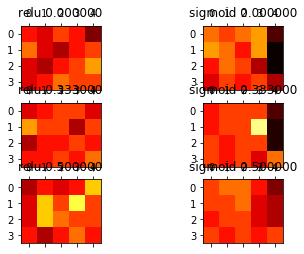



Dropout 0.000000 Activation: relu 
array([[ 0.57746479,  0.56338028,  0.5915493 ,  0.57746479,  0.53521127],
       [ 0.6056338 ,  0.56338028,  0.54929577,  0.57746479,  0.5915493 ],
       [ 0.56338028,  0.54929577,  0.57746479,  0.5915493 ,  0.61971831],
       [ 0.56338028,  0.57746479,  0.6056338 ,  0.5915493 ,  0.5915493 ]])

Max: 0.619718
Avg: 0.578169
Col Avg: array([ 0.57746479,  0.56338028,  0.58098592,  0.58450704,  0.58450704])
Row Avg: array([ 0.56901408,  0.57746479,  0.58028169,  0.58591549])


Dropout 0.000000 Activation: sigmoid 
array([[ 0.6056338 ,  0.5915493 ,  0.6056338 ,  0.61971831,  0.52112676],
       [ 0.61971831,  0.6056338 ,  0.57746479,  0.61971831,  0.49295775],
       [ 0.57746479,  0.6056338 ,  0.5915493 ,  0.54929577,  0.49295775],
       [ 0.56338028,  0.5915493 ,  0.57746479,  0.5915493 ,  0.54929577]])

Max: 0.619718
Avg: 0.577465
Col Avg: array([ 0.5915493 ,  0.59859155,  0.58802817,  0.59507042,  0.51408451])
Row Avg: array([ 0.58873239,  0.583098

In [15]:
# visualize evaluations in a grid to pick one

f, subplots = plt.subplots(len(dropout_hp), len(activation_hp))

outstr = ""

rownum=0
for dr in dropout_hp:
    colnum = 0
    for ac in activation_hp:
        matrix1 = []
        for hl in hidden_layer_hp:
            row = []
            for reg_penalty in reg_penalty_hp:
                try:
                    row.append(fscores[(hl, reg_penalty, dr, ac)])
                except KeyError:
                    row.append(0.00)
            matrix1.append(row)
            
        outstr += "\n\nDropout %f Activation: %s \n" % (dr, ac)
        outstr += repr(np.array(matrix1))
        outstr += "\n\nMax: %f\n" % (np.max(np.array(matrix1)))
        outstr += "Avg: %f\n" % (np.average(np.array(matrix1)))
        outstr += "Col Avg: %s\n" % repr(np.average(np.array(matrix1), axis=0))
        outstr += "Row Avg: %s\n" % repr(np.average(np.array(matrix1), axis=1))

        subplots[rownum, colnum].matshow(matrix1, cmap='hot', vmin=0.5, vmax=0.7, interpolation='nearest')
        subplots[rownum, colnum].set_title('%s %f' % (ac, dr))

        colnum += 1  
    rownum += 1

plt.show()

print(outstr)


In [18]:
# pick this model, load from file
ac='sigmoid'
hl = 8
dr = 0.333
rp = 0.001
modelname = "model_%s_%d_%.3f_%.6f" % (ac, hl, dr, rp)

# doesn't work because of some custom metric BS
#keras.models.load_model("%s.h5" % modelname)

with open("%s.json" % modelname, 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights("%s_weights.h5" % modelname)
print("Loaded model from disk")



Loaded model from disk


In [19]:
# re-evaluate in xval to confirm, pick threshold value
y_xval_prob = model.predict(X_xval)
                
thresh, score = selectThresholdAcc(y_xval_prob, y_xval)
y_xval_pred = y_xval_prob >= thresh
                
print("Final Xval Accuracy %.3f, Xval F1 %.3f, f_score %.3f" % 
      (sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
       sklearn.metrics.f1_score(y_xval_pred, y_xval),
       score))
                                
confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
print(confusion_matrix)
false_positive = confusion_matrix[1][0]
false_negative = confusion_matrix[0][1]
true_positive = confusion_matrix[1][1]


Final Xval Accuracy 0.676, Xval F1 0.623, f_score 0.676
[[29 16]
 [ 7 19]]


In [20]:
# evaluate in test set
# xval not a good measure of expected performance since we used it to pick threshold
# also tested many times in xval and picked best model, which is probably model that's lucky in xval
y_test_prob = model.predict(X_test)

y_test_pred = y_test_prob >= thresh

print("Test Accuracy %.3f, Test F1 %.3f" % 
      (sklearn.metrics.accuracy_score(y_test_pred, y_test), 
       sklearn.metrics.f1_score(y_test_pred, y_test)))

print(sklearn.metrics.confusion_matrix(y_test_pred, y_test))

Test Accuracy 0.563, Test F1 0.475
[[26 20]
 [11 14]]


In [21]:
model.save("finalmodel.h5")
model.save_weights("modelweights.h5")

with open("finalmodel.json", "wb") as fjson:
    fjson.write(model.to_json())